In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import *
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from kneed import KneeLocator

In [3]:
df = pd.read_pickle("./dataunderstanding.pkl")
df

,vocal_channel,emotion,emotional_intensity,repetition,sex,channels,frame_width,length_ms,frame_count,intensity,...,kur,skew,angry,calm,disgust,fearful,happy,neutral,sad,surprised
0,0,fearful,0,2,1,1,2,3737,179379.0,-36.793432,...,9.406061,0.273153,0,0,0,1,0,0,0,0
1,0,angry,0,1,1,1,2,3904,187387.0,-37.443235,...,19.564187,0.292157,1,0,0,0,0,0,0,0
2,0,happy,1,2,1,1,2,4671,224224.0,-32.290737,...,4.881241,0.302659,0,0,0,0,1,0,0,0
3,0,surprised,0,1,1,1,2,3637,174575.0,-49.019839,...,13.040259,-0.081014,0,0,0,0,0,0,0,1
4,1,happy,1,2,1,1,2,4404,211411.0,-31.214503,...,7.485109,0.414872,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,0,calm,1,1,0,1,2,4605,221021.0,-42.136827,...,9.551363,0.759247,0,1,0,0,0,0,0,0
2448,0,calm,0,1,0,1,2,4171,200200.0,-43.342901,...,22.517991,1.073633,0,1,0,0,0,0,0,0
2449,1,sad,1,2,0,1,2,5239,251451.0,-37.919308,...,4.964319,-0.005821,0,0,0,0,0,0,1,0
2450,0,surprised,0,1,0,1,2,3737,179379.0,-45.751265,...,13.855588,-0.110966,0,0,0,0,0,0,0,1


# Feature selection

In [4]:
#drop columns not useful for analisys
dfnaf = df.drop(['emotion','channels','length_ms','emotional_intensity', 'repetition',
       'frame_width', 'angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral','sad', 'surprised',
                 'sex','vocal_channel'], axis =1)
# remove columns with std dev less than 0.1
std_dev = dfnaf.std()
columns_to_keep = std_dev[std_dev >= 0.1].index
dfnaf = dfnaf[columns_to_keep]
dfnaf

,frame_count,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_kur,stft_skew,max,kur,skew
0,179379.0,-36.793432,16995,-33.485947,134.654860,-755.22345,171.69092,5792.550744,3328.055457,0.000000,11985.300650,-1.120769,0.250940,-1.215025,0.403514,0.138947,9.406061,0.273153
1,187387.0,-37.443235,13906,-29.502108,130.485630,-713.98560,205.00770,5197.620555,4040.931570,0.000000,12000.290443,-1.531204,0.219582,-1.384174,0.290905,0.263062,19.564187,0.292157
2,224224.0,-32.290737,18723,-30.532463,126.577110,-726.06036,165.45653,4830.743037,3332.131300,0.000000,12007.751173,-1.130153,0.436699,-1.242947,0.470350,0.166351,4.881241,0.302659
3,174575.0,-49.019839,11617,-36.059555,159.725160,-842.94635,190.03609,5376.446478,4053.663073,0.000000,12048.223893,-1.497765,0.098802,-1.445318,0.274756,0.024078,13.040259,-0.081014
4,211411.0,-31.214503,15137,-31.405996,122.125824,-700.70276,161.13400,5146.012474,3442.724109,0.000000,12025.582707,-1.167544,0.496066,-1.366742,0.318926,0.242676,7.485109,0.414872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,221021.0,-42.136827,9871,-30.225578,158.845500,-855.92420,208.18497,5886.647366,4114.260257,0.000000,12210.517144,-1.588861,0.184390,-1.075888,-0.310088,0.052399,9.551363,0.759247
2448,200200.0,-43.342901,8963,-31.160332,157.499700,-825.37410,220.79490,6602.742127,4191.727090,0.000000,12064.561791,-1.614582,-0.113920,-1.026071,-0.408018,0.084045,22.517991,1.073633
2449,251451.0,-37.919308,9765,-26.135280,138.133210,-768.36536,235.53938,4654.156076,4231.511986,0.000000,12207.179884,-1.337419,0.619346,-1.473789,0.130310,0.097260,4.964319,-0.005821
2450,179379.0,-45.751265,9716,-28.242815,159.943400,-868.09576,219.84350,5524.736973,3596.031841,760.822547,11981.912464,-1.465594,0.206481,-1.277117,-0.242668,0.052002,13.855588,-0.110966


In [5]:
pca = PCA()

In [6]:
X_pca = pca.fit_transform(dfnaf.values)
X_pca

array([[-1.63920287e+04,  4.98194036e+03, -3.55583597e+02, ...,
        -1.18923752e-01, -4.56598675e-02, -5.32112649e-04],
       [-8.50115944e+03,  1.54829095e+03, -2.95037026e+02, ...,
        -5.93532029e-02, -1.18303225e-01, -8.93770738e-02],
       [ 2.84955362e+04,  4.99237970e+03, -2.28834454e+02, ...,
         5.62765516e-02,  1.75512475e-02, -4.62306381e-03],
       ...,
       [ 5.53587645e+04, -5.01798800e+03, -8.84828600e+02, ...,
         3.08128539e-03, -4.83959423e-02,  1.90398502e-02],
       [-1.66659046e+04, -2.27656991e+03, -1.33597947e+02, ...,
        -9.06673021e-03,  3.59821600e-02,  1.02130414e-02],
       [-1.18853816e+04, -2.77281546e+03, -9.59577936e+02, ...,
        -1.63968610e-03,  6.20708210e-02,  2.32172744e-02]])

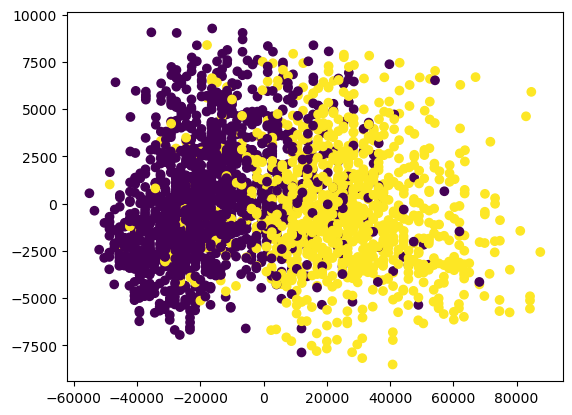

In [7]:
# we can see a clear separation between Sing or Speech
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['vocal_channel'])
plt.show()

In [8]:
scaler = MinMaxScaler()
dfs = df[['intensity','zero_crossings_sum', 'mfcc_mean', 'mfcc_std', 'mfcc_min','mfcc_max',
          'sc_mean', 'sc_std', 'sc_min', 'sc_max', 'sc_kur', 'sc_skew','stft_mean', 'stft_std', 
          'stft_min', 'stft_kur', 'stft_skew', 'mean','std', 'min', 'max', 'kur', 'skew']]
dfs_val = dfs.values
dfs_tse = scaler.fit_transform(dfs_val)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(dfs_tse)

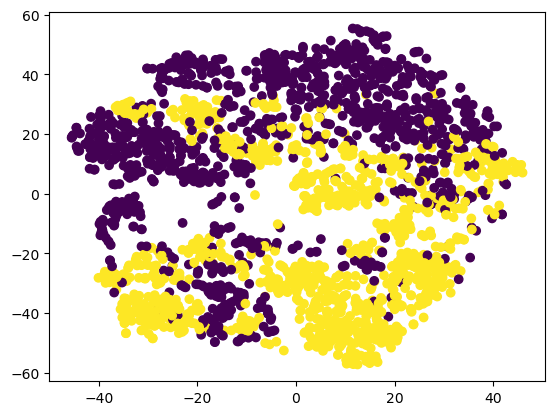

In [9]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['sex'])
plt.show()

# Clustering Analysis by K-means
Choice of attributes and distance function

Identification of the best value of k 

Characterization of the obtained clusters by using both analysis of the k centroids and comparison of the distribution of variables within the clusters and that in the whole dataset

In [10]:
scaler = MinMaxScaler()

In [11]:
train_data = scaler.fit_transform(dfnaf)

In [12]:
dfnaf.describe()

,frame_count,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_kur,stft_skew,max,kur,skew
count,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000
mean,195941.919250,-37.523903,12626.284666,-28.764989,136.749280,-757.720708,199.159198,5174.237533,3385.597001,551.834124,11879.842561,-1.254885,0.331826,-1.267129,0.114301,0.131009,10.405500,-0.037788
std,27988.209884,7.584198,3298.462175,4.374993,20.417601,97.736013,25.955043,867.728605,555.143587,508.025890,416.678492,0.331711,0.330645,0.169791,0.323456,0.103130,4.930312,0.424329
min,140941.000000,-58.267799,4721.000000,-41.191696,83.621370,-1025.026900,126.250810,2896.904456,1911.508213,0.000000,10653.529197,-1.795576,-0.510390,-1.669603,-0.719104,0.004669,1.757794,-1.220111
25%,172973.000000,-42.605828,10299.500000,-31.824468,122.623928,-824.990785,180.081417,4567.038239,3041.167731,0.000000,11763.679073,-1.506880,0.090934,-1.392241,-0.093044,0.052277,6.442270,-0.323773
50%,192192.000000,-37.287958,12289.000000,-28.673228,136.494260,-760.241480,201.697175,5124.589513,3440.558954,707.319256,12003.113606,-1.334025,0.337461,-1.297719,0.127321,0.099518,9.615892,0.006904
75%,217817.000000,-32.433785,14759.000000,-25.558831,151.376782,-692.890015,218.185288,5776.235535,3770.948709,977.693852,12078.551484,-1.078887,0.547781,-1.163587,0.335574,0.183510,13.603518,0.262978
max,283483.000000,-17.070853,21832.000000,-16.818872,193.372210,-500.365480,268.987580,7482.657171,4819.783069,2121.417965,12945.782914,-0.220260,1.236986,-0.795410,0.978619,0.477356,25.373097,1.159727


# Kmeans

In [13]:
%%time
sse_list = []
for k in range(2, 30):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(train_data)
    sse_list.append(kmeans.inertia_)

CPU times: total: 4.02 s
Wall time: 1.61 s


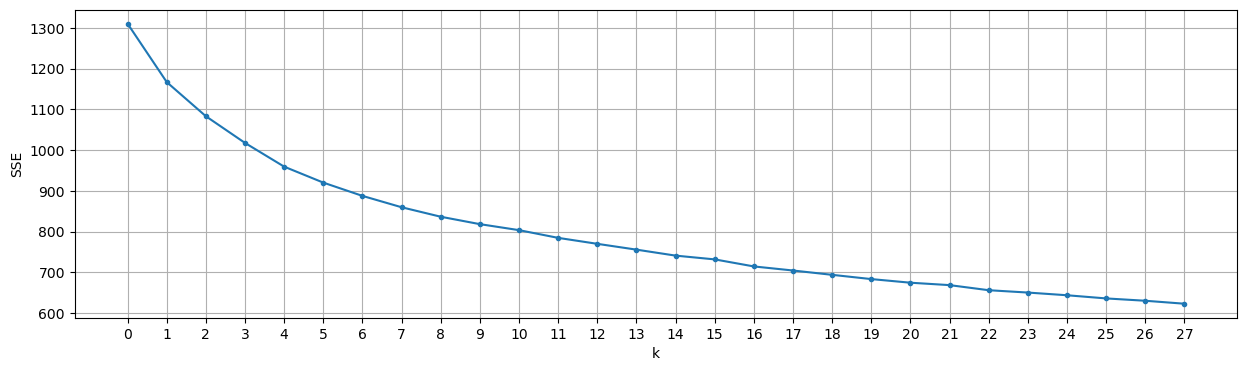

In [14]:
plt.figure(figsize=(15,4))
plt.plot(range(len(sse_list)), sse_list, marker='.')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(range(len(sse_list)))
plt.grid()
plt.show()

In [15]:
kmeans = KMeans(init='k-means++', n_clusters=10, n_init=10, max_iter=100)
kmeans.fit(train_data)
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(train_data, kmeans.labels_))

labels {0: 219, 1: 271, 2: 240, 3: 198, 4: 332, 5: 244, 6: 244, 7: 210, 8: 271, 9: 223}
sse 836.8486331695153
silhouette 0.12367363678880954


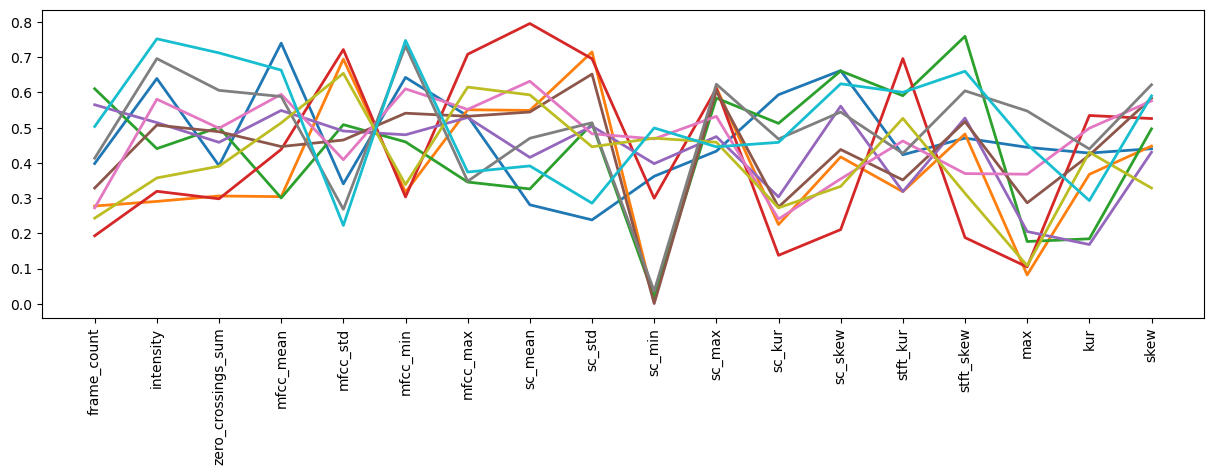

In [16]:
plt.figure(figsize=(15,4))
for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, 18), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=2)
plt.xticks(range(0, 18), list(dfnaf.columns),rotation = 90)
plt.show()

In [17]:
df_clusters = dfnaf.copy()
df_clusters['Labels'] = kmeans.labels_

In [18]:
df_clusters.head()

,frame_count,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_kur,stft_skew,max,kur,skew,Labels
0,179379.0,-36.793432,16995,-33.485947,134.654860,-755.22345,171.69092,5792.550744,3328.055457,0.0,11985.300650,-1.120769,0.250940,-1.215025,0.403514,0.138947,9.406061,0.273153,5
1,187387.0,-37.443235,13906,-29.502108,130.485630,-713.98560,205.00770,5197.620555,4040.931570,0.0,12000.290443,-1.531204,0.219582,-1.384174,0.290905,0.263062,19.564187,0.292157,5
2,224224.0,-32.290737,18723,-30.532463,126.577110,-726.06036,165.45653,4830.743037,3332.131300,0.0,12007.751173,-1.130153,0.436699,-1.242947,0.470350,0.166351,4.881241,0.302659,2
3,174575.0,-49.019839,11617,-36.059555,159.725160,-842.94635,190.03609,5376.446478,4053.663073,0.0,12048.223893,-1.497765,0.098802,-1.445318,0.274756,0.024078,13.040259,-0.081014,1
4,211411.0,-31.214503,15137,-31.405996,122.125824,-700.70276,161.13400,5146.012474,3442.724109,0.0,12025.582707,-1.167544,0.496066,-1.366742,0.318926,0.242676,7.485109,0.414872,7


In [19]:
# we can see Kmeans is a good type of clustering to discover differences between song and speech, non serve proprio
# per sex

In [20]:
kmeans = KMeans(n_clusters=9, n_init=10, max_iter=100)
kmeans.fit(train_data)

KMeans(max_iter=100, n_clusters=9, n_init=10)

In [21]:
kmeans.labels_

array([5, 5, 0, ..., 7, 1, 2])

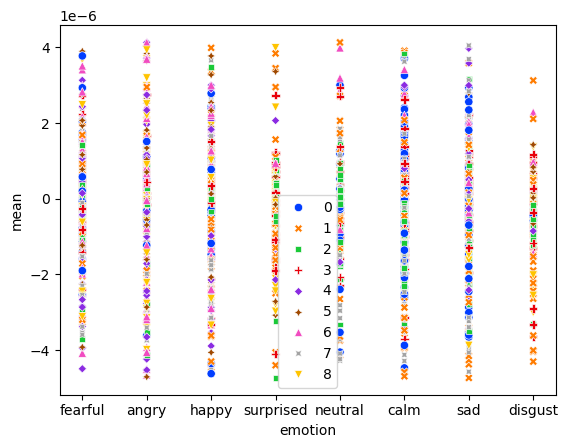

In [22]:
sns.scatterplot(data=df, x="emotion", y="mean", hue=kmeans.labels_, style=kmeans.labels_,
                palette="bright")
plt.show()

In [23]:
labels, sizes = np.unique(kmeans.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(dfnaf)))

Cluster 0, size 246 (0.10)
Cluster 1, size 281 (0.11)
Cluster 2, size 395 (0.16)
Cluster 3, size 176 (0.07)
Cluster 4, size 229 (0.09)
Cluster 5, size 306 (0.12)
Cluster 6, size 222 (0.09)
Cluster 7, size 343 (0.14)
Cluster 8, size 254 (0.10)


In [24]:
from scipy.spatial.distance import pdist, squareform

In [25]:
D = squareform(pdist(train_data))
D

array([[0.        , 0.75223239, 0.49441324, ..., 1.0624924 , 0.96025481,
        0.87817986],
       [0.75223239, 0.        , 0.92403257, ..., 0.9876628 , 0.91368601,
        0.77069197],
       [0.49441324, 0.92403257, 0.        , ..., 0.94941533, 1.19841177,
        1.11077342],
       ...,
       [1.0624924 , 0.9876628 , 0.94941533, ..., 0.        , 0.96086472,
        0.9320341 ],
       [0.96025481, 0.91368601, 1.19841177, ..., 0.96086472, 0.        ,
        0.68032282],
       [0.87817986, 0.77069197, 1.11077342, ..., 0.9320341 , 0.68032282,
        0.        ]])

In [26]:
silhouette_score(D, kmeans.labels_, metric='precomputed')

0.13524197712748287

In [27]:
sil_samples = silhouette_samples(D, kmeans.labels_, metric='precomputed')
np.mean(sil_samples)

0.13524197712748287

In [28]:
sse_list = list()
sil_list = list()
max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans.fit(train_data)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(D, kmeans.labels_, metric='precomputed'))

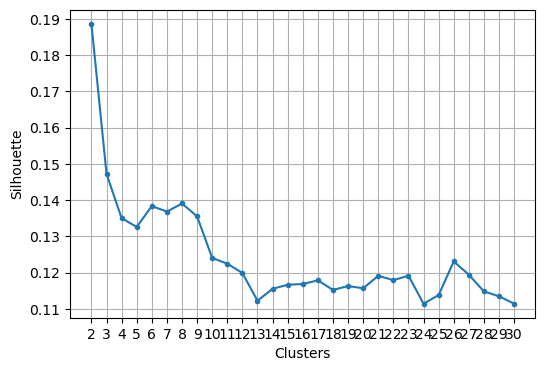

In [29]:
plt.figure(figsize=(6,4))
plt.plot(range(2, max_k + 1), sil_list, marker='.')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.xticks(range(2, max_k + 1))
plt.grid()
plt.show()

<Figure size 600x400 with 0 Axes>

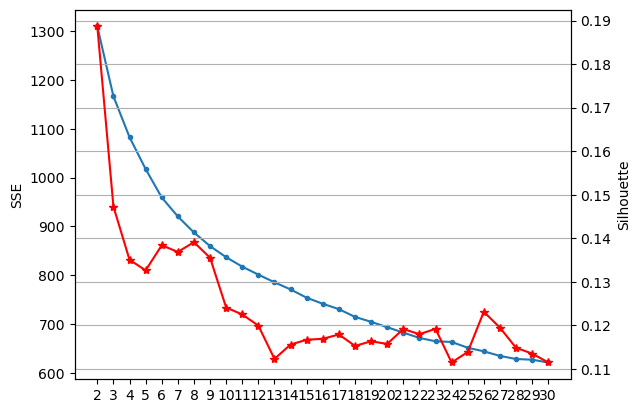

In [30]:
plt.figure(figsize=(6,4))
fig, ax1 = plt.subplots()

ax1.plot(range(2, max_k + 1), sse_list, marker='.')
ax1.set_ylabel('SSE')

ax2 = ax1.twinx()
ax2.plot(range(2, max_k + 1), sil_list, marker='*', c='r')
ax2.set_ylabel('Silhouette')

plt.xlabel('k')
plt.xticks(range(2, max_k + 1))
plt.grid()
plt.show()

# We choose 6 clusters beacuse it has the higher silhouette and a relatively low SSE

In [31]:
kmeans = KMeans(n_clusters= 6, n_init=100, max_iter=300, random_state=0)
kmeans.fit_predict(train_data)

array([4, 4, 3, ..., 5, 1, 2])

In [32]:
kmeans.inertia_

959.3935373440548

In [33]:
silhouette_score(D, kmeans.labels_, metric='precomputed')

0.13813688114914488

In [34]:
labels, sizes = np.unique(kmeans.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(dfnaf)))

Cluster 0, size 412 (0.17)
Cluster 1, size 465 (0.19)
Cluster 2, size 434 (0.18)
Cluster 3, size 309 (0.13)
Cluster 4, size 379 (0.15)
Cluster 5, size 453 (0.18)


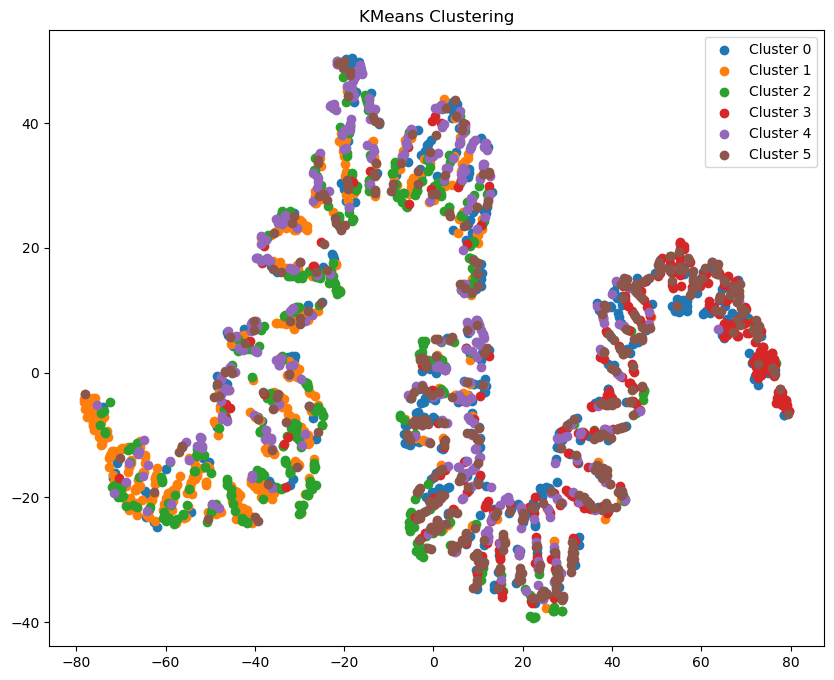

In [35]:
df['kmeans_label'] = kmeans.labels_

X_tsne = tsne.fit_transform(dfnaf.values)
X_tsne
# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(6):  # Assuming 11 clusters
    cluster_points = X_tsne[df['kmeans_label'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

plt.title('KMeans Clustering')
plt.legend()
plt.show()

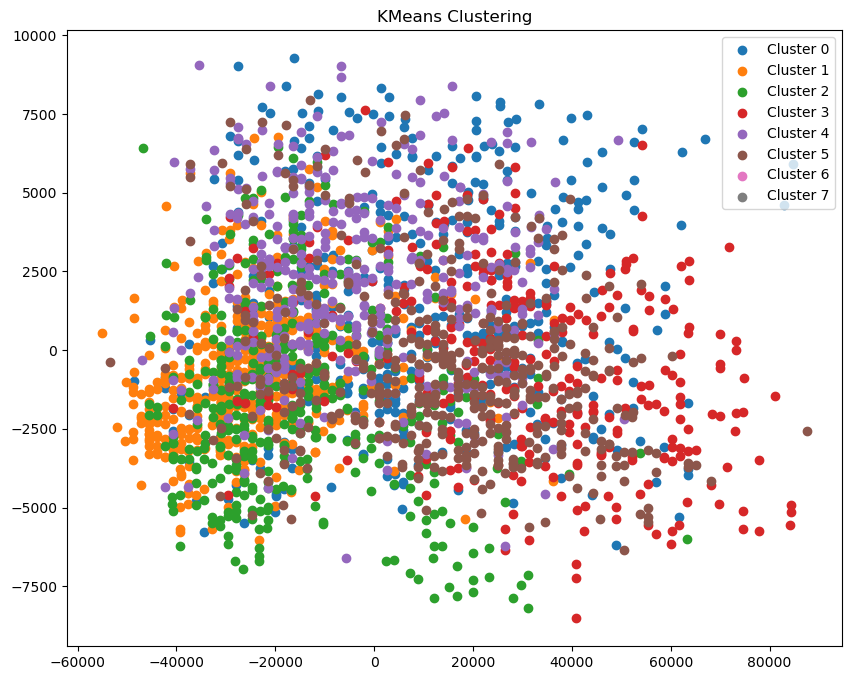

In [36]:
X_pca = pca.fit_transform(dfnaf.values)
X_pca
# Plot the clusters

plt.figure(figsize=(10, 8))
for i in range(8):  # Assuming 11 clusters
    cluster_points = X_pca[df['kmeans_label'] == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
 
plt.title('KMeans Clustering')
plt.legend()
plt.show()

In [37]:
df['kmeans_label'] = kmeans.labels_
df

,vocal_channel,emotion,emotional_intensity,repetition,sex,channels,frame_width,length_ms,frame_count,intensity,...,skew,angry,calm,disgust,fearful,happy,neutral,sad,surprised,kmeans_label
0,0,fearful,0,2,1,1,2,3737,179379.0,-36.793432,...,0.273153,0,0,0,1,0,0,0,0,4
1,0,angry,0,1,1,1,2,3904,187387.0,-37.443235,...,0.292157,1,0,0,0,0,0,0,0,4
2,0,happy,1,2,1,1,2,4671,224224.0,-32.290737,...,0.302659,0,0,0,0,1,0,0,0,3
3,0,surprised,0,1,1,1,2,3637,174575.0,-49.019839,...,-0.081014,0,0,0,0,0,0,0,1,2
4,1,happy,1,2,1,1,2,4404,211411.0,-31.214503,...,0.414872,0,0,0,0,1,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,0,calm,1,1,0,1,2,4605,221021.0,-42.136827,...,0.759247,0,1,0,0,0,0,0,0,2
2448,0,calm,0,1,0,1,2,4171,200200.0,-43.342901,...,1.073633,0,1,0,0,0,0,0,0,1
2449,1,sad,1,2,0,1,2,5239,251451.0,-37.919308,...,-0.005821,0,0,0,0,0,0,1,0,5
2450,0,surprised,0,1,0,1,2,3737,179379.0,-45.751265,...,-0.110966,0,0,0,0,0,0,0,1,1


In [38]:
vocal_xt2 = pd.crosstab(df['vocal_channel'], df['kmeans_label'])
vocal_xt2 = pd.crosstab(df['kmeans_label'], df['vocal_channel'])

vocal_xt2

vocal_channel,0,1
kmeans_label,,
0,172,240
1,451,14
2,361,73
3,48,261
4,265,114
5,155,298


In [39]:
sex_xt2 = pd.crosstab(df['sex'], df['kmeans_label'])
sex_xt2 = pd.crosstab(df['kmeans_label'], df['sex'])

sex_xt2

sex,0,1
kmeans_label,,
0,258,154
1,366,99
2,140,294
3,53,256
4,107,272
5,324,129


In [40]:
emotion_xt2 = pd.crosstab(df['emotion'], df['kmeans_label'])
emotion_xt2 = pd.crosstab(df['kmeans_label'], df['emotion'])

emotion_xt2

emotion,angry,calm,disgust,fearful,happy,neutral,sad,surprised
kmeans_label,,,,,,,,
0,141,20,16,116,82,5,26,6
1,29,82,61,38,58,53,76,68
2,20,94,52,34,43,52,77,62
3,18,90,11,37,47,29,75,2
4,131,0,23,79,81,0,25,40
5,37,90,29,72,65,49,97,14


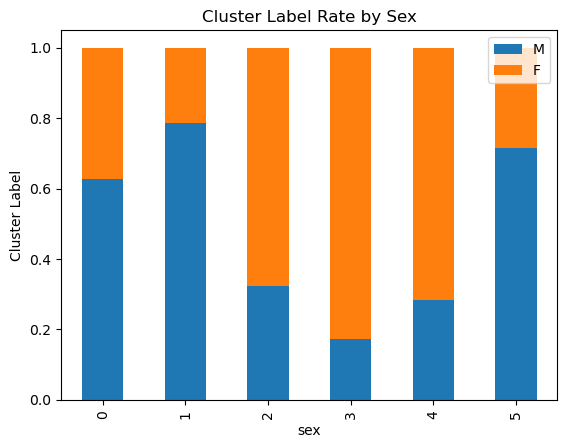

In [41]:
#removing the columns with variance lower than 0.1 i can assure where 
sex_xt2_pct = sex_xt2.div(sex_xt2.sum(1).astype(float), axis=0)
sex_xt2_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by Sex')
plt.xlabel('sex')
plt.ylabel('Cluster Label')
plt.legend(['M','F'])
plt.show()

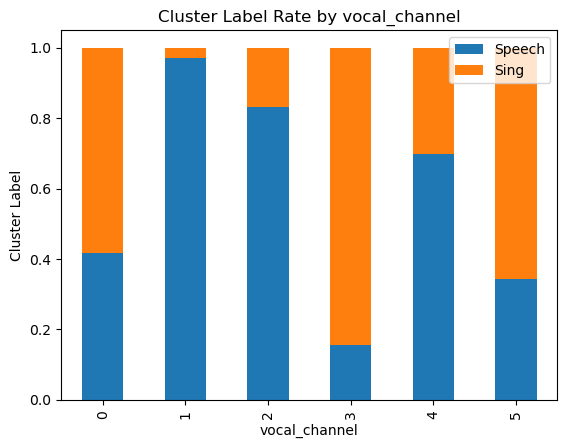

In [42]:
#removing the columns with variance lower than 0.1 i can assure where 
vocal_xt2_pct = vocal_xt2.div(vocal_xt2.sum(1).astype(float), axis=0)
vocal_xt2_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by vocal_channel')
plt.xlabel('vocal_channel')
plt.ylabel('Cluster Label')
plt.legend(['Speech','Sing'])
plt.show()

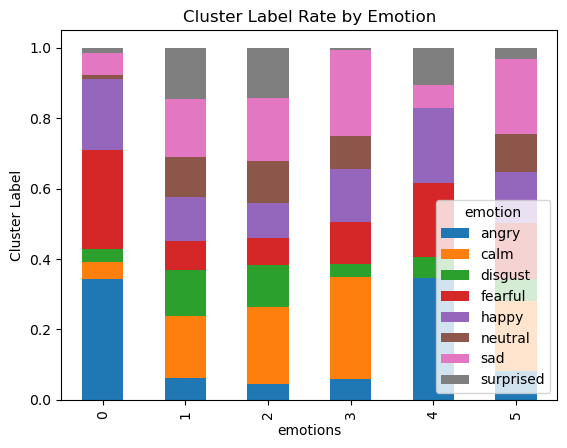

In [43]:
#removing the columns with variance lower than 0.1 i can assure where 
emotion_xt2_pct = emotion_xt2.div(emotion_xt2.sum(1).astype(float), axis=0)
emotion_xt2_pct.plot(kind='bar', stacked=True, title='Cluster Label Rate by Emotion')
plt.xlabel('emotions')
plt.ylabel('Cluster Label')
plt.show()

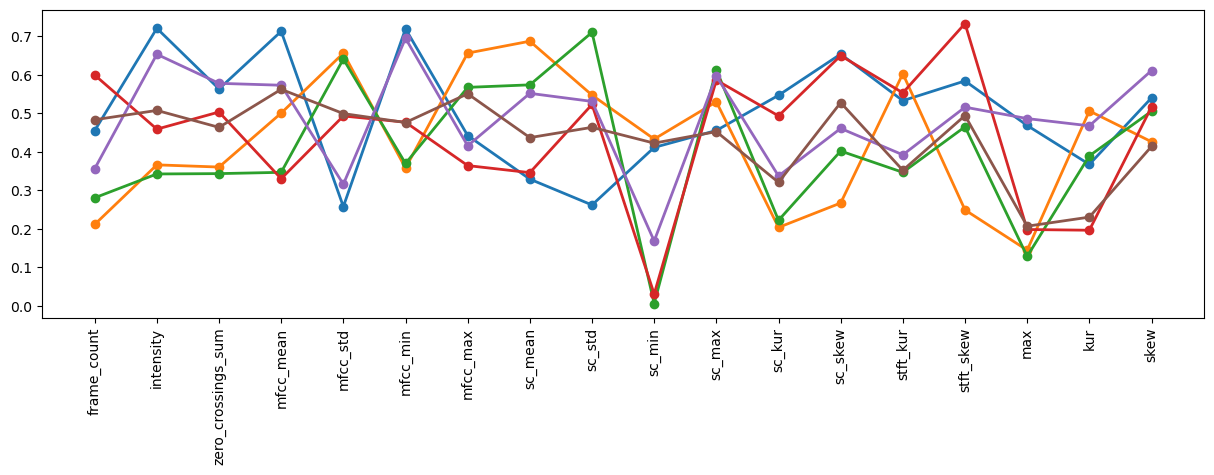

In [44]:
plt.figure(figsize=(15,4))
for i in range(len(kmeans.cluster_centers_)):
    plt.plot(range(0, 18), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=2, marker='o')
plt.xticks(range(0, 18), list(dfnaf.columns),rotation = 90)
plt.show()

# Analysis by density-based clustering
### Choice of attributes and distance function 
### Study of the clustering parameters
### Characterization and interpretation of the obtained clusters

In [45]:
# density based clustering
print('dbscan')

dbscan = DBSCAN(eps=0.5, min_samples=4, metric='euclidean')
dbscan.fit(train_data)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, dbscan.labels_))

dbscan
labels {-1: 288, 0: 2160, 1: 4, 2: 0}
silhouette 0.03340649390736909


In [46]:
labels, sizes = np.unique(dbscan.labels_, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(train_data)))

Cluster -1, size 288 (0.12)
Cluster 0, size 2160 (0.88)
Cluster 1, size 4 (0.00)


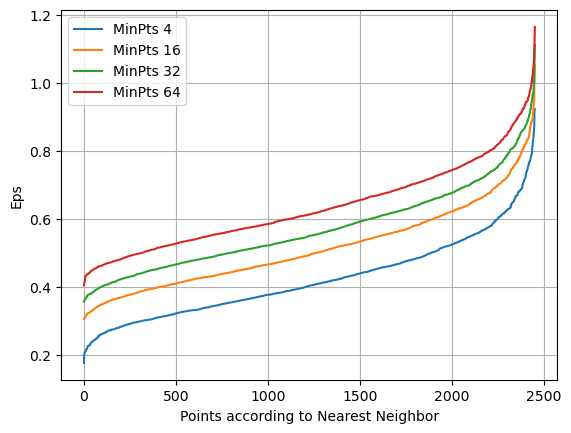

In [47]:
for min_pts in [4, 16, 32, 64]:
    min_pts_distance = list()

    for i in range(len(train_data)):
        neigh_idx = np.argsort(D[i])[min_pts]
        min_pts_distance.append(D[i, neigh_idx])

    plt.plot(range(len(train_data)), sorted(min_pts_distance), label='MinPts %s' % min_pts)
plt.xlabel('Points according to Nearest Neighbor')
plt.ylabel('Eps')
plt.yticks()
plt.grid()
plt.legend()
plt.show()

In [48]:
from kneed import KneeLocator

0.613125646932833


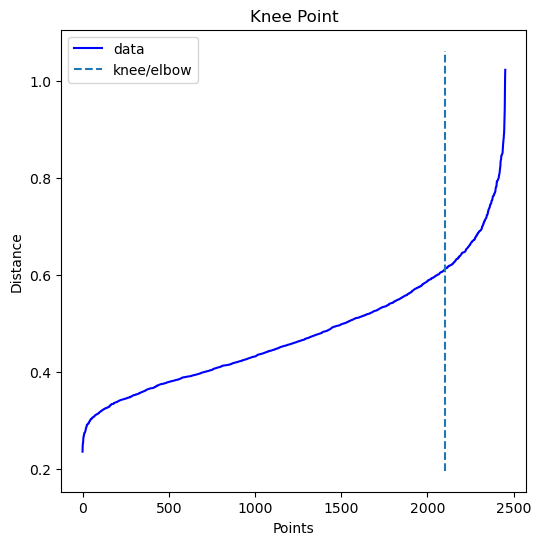

In [49]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(train_data)
distances, indices = neighbors.kneighbors(train_data)

distances = np.sort(distances[:,10], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')


knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])


In [50]:
# density based clustering
print('dbscan')

dbscan = DBSCAN(eps=distances[knee.knee], min_samples=4, metric='euclidean')
dbscan.fit(train_data)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, dbscan.labels_))

dbscan
labels {-1: 73, 0: 2379, 1: 0}
silhouette 0.18861150724766051


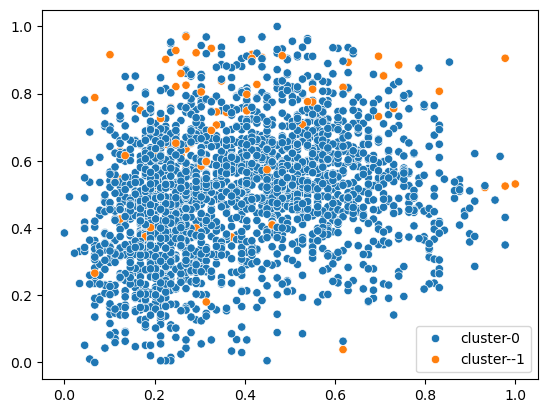

In [51]:
labels = dbscan.labels_

sns.scatterplot(x=train_data[:, 0], y=train_data[:, 1], hue=["cluster-{}".format(x) for x in labels])
plt.show()

In [52]:
df['dbscan_labels']=dbscan.labels_
df

,vocal_channel,emotion,emotional_intensity,repetition,sex,channels,frame_width,length_ms,frame_count,intensity,...,angry,calm,disgust,fearful,happy,neutral,sad,surprised,kmeans_label,dbscan_labels
0,0,fearful,0,2,1,1,2,3737,179379.0,-36.793432,...,0,0,0,1,0,0,0,0,4,0
1,0,angry,0,1,1,1,2,3904,187387.0,-37.443235,...,1,0,0,0,0,0,0,0,4,0
2,0,happy,1,2,1,1,2,4671,224224.0,-32.290737,...,0,0,0,0,1,0,0,0,3,0
3,0,surprised,0,1,1,1,2,3637,174575.0,-49.019839,...,0,0,0,0,0,0,0,1,2,0
4,1,happy,1,2,1,1,2,4404,211411.0,-31.214503,...,0,0,0,0,1,0,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,0,calm,1,1,0,1,2,4605,221021.0,-42.136827,...,0,1,0,0,0,0,0,0,2,0
2448,0,calm,0,1,0,1,2,4171,200200.0,-43.342901,...,0,1,0,0,0,0,0,0,1,0
2449,1,sad,1,2,0,1,2,5239,251451.0,-37.919308,...,0,0,0,0,0,0,1,0,5,0
2450,0,surprised,0,1,0,1,2,3737,179379.0,-45.751265,...,0,0,0,0,0,0,0,1,1,0


# Analysis by hierarchical clustering
### Choice of attributes and distance function
### Show and discuss different dendograms using different algorithms

In [53]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [54]:
Ds = pdist(train_data)

In [55]:
links = linkage(Ds, method = 'complete')

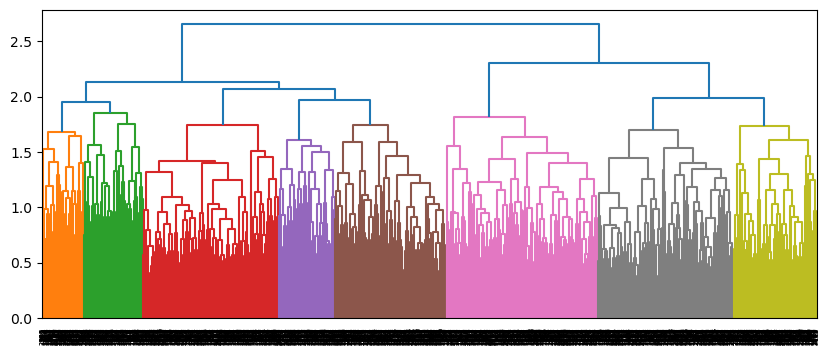

In [56]:
plt.figure(figsize=(10,4))
plt.yticks()
res = dendrogram(links)

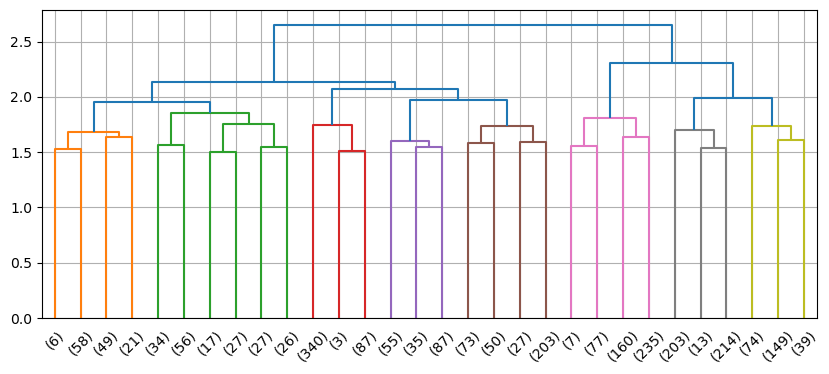

In [57]:
plt.figure(figsize=(10,4))
res = dendrogram(links,truncate_mode="lastp")
plt.grid()
plt.show()

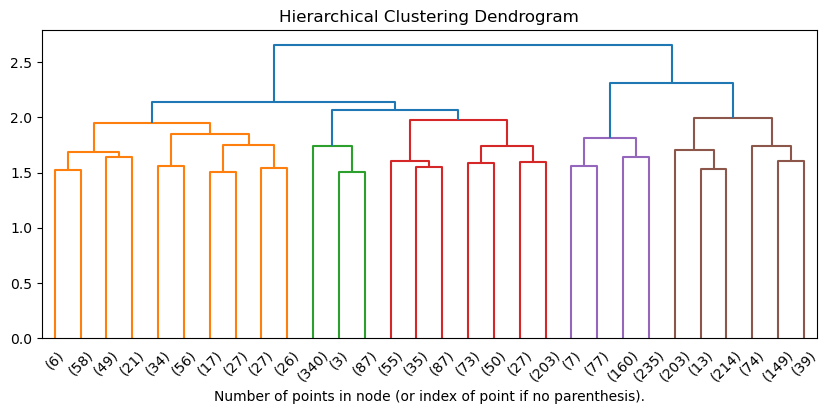

In [58]:
plt.figure(figsize=(10,4))
plt.title("Hierarchical Clustering Dendrogram")
res = dendrogram(links,truncate_mode="lastp",color_threshold=2)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [59]:
hier_labels = fcluster(links,t=2,criterion='distance')

In [60]:
labels, sizes = np.unique(hier_labels, return_counts=True)
for l, s in zip(labels, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(train_data)))

Cluster 1, size 321 (0.13)
Cluster 2, size 430 (0.18)
Cluster 3, size 530 (0.22)
Cluster 4, size 479 (0.20)
Cluster 5, size 692 (0.28)


In [61]:
hier_centers = list()
for l in sorted(np.unique(hier_labels)):
    if l == -1:
        continue
    hier_centers.append(np.mean(train_data[hier_labels == l], axis=0))
hier_centers = np.array(hier_centers)

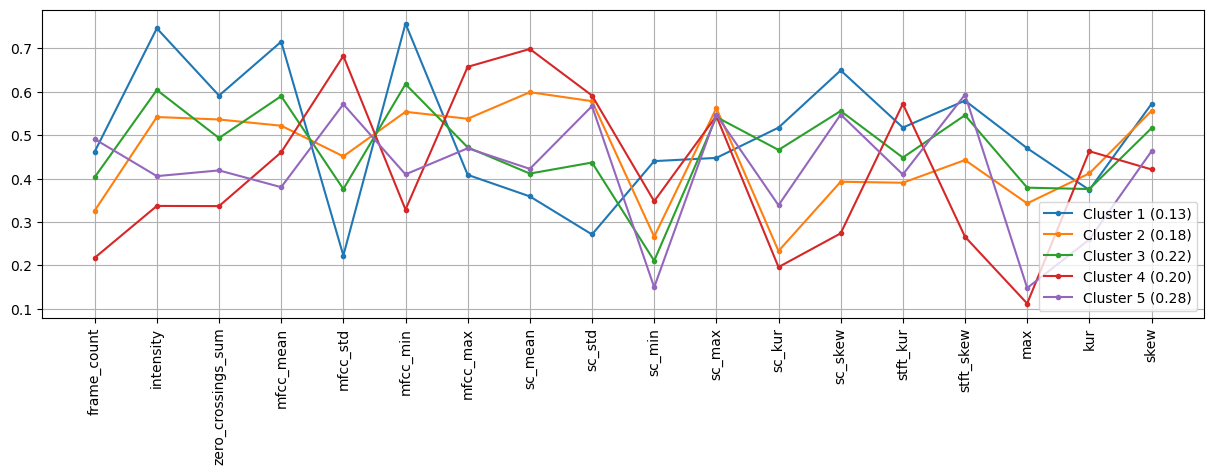

In [62]:
labels, sizes = np.unique(hier_labels, return_counts=True)
plt.figure(figsize=(15,4))
for l in np.unique(hier_labels):
    if l == -1:
        continue
    plt.plot(dfnaf.columns, hier_centers[l-1], marker='.', 
             label='Cluster %s (%.2f)' % (l, sizes[l-1]/len(train_data)))
plt.xticks(rotation = 90)
plt.grid()
plt.legend()
plt.show()

In [63]:
silhouette_score(train_data, hier_labels)

0.059635265362187016

In [64]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', linkage='complete')
model = model.fit(train_data)

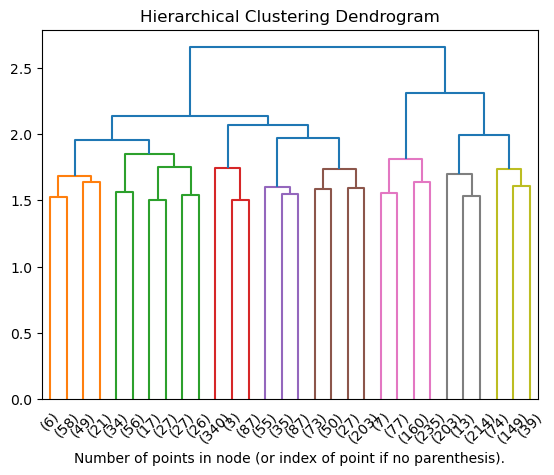

In [65]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [66]:
hier = AgglomerativeClustering(n_clusters=6, metric='euclidean', linkage='complete')
hier.fit(train_data)

AgglomerativeClustering(linkage='complete', metric='euclidean', n_clusters=6)

In [67]:
hist, bins = np.histogram(hier.labels_, bins=range(0, len(set(hier.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, hier.labels_))

labels {0: 530, 1: 321, 2: 479, 3: 262, 4: 430, 5: 430}
silhouette 0.06374028238477723


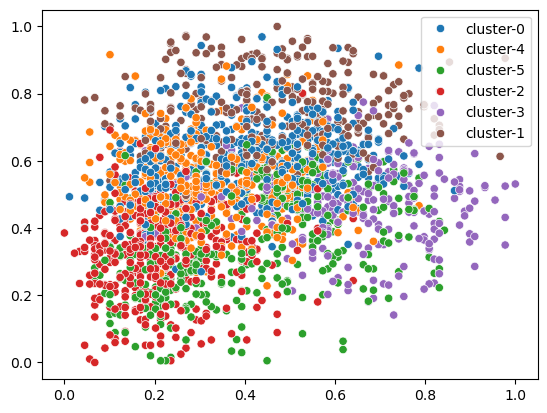

In [68]:
labels = hier.labels_
sns.scatterplot(x=train_data[:, 0], y=train_data[:, 1], hue=["cluster-{}".format(x) for x in labels])
plt.show()

In [69]:
# hierarchical clustering
connectivity = kneighbors_graph(train_data, n_neighbors=100, include_self=False)

In [70]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='euclidean', 
                                linkage='ward', connectivity=connectivity)
model = model.fit(train_data)

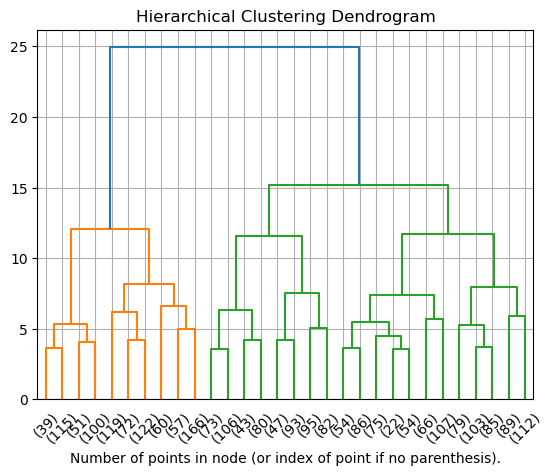

In [71]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.grid()
plt.show()

In [72]:
ward = AgglomerativeClustering(n_clusters=6, linkage='ward', metric='euclidean',
                                   connectivity=connectivity)
ward.fit(train_data)

hist, bins = np.histogram(ward.labels_, bins=range(0, len(set(ward.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, ward.labels_))

labels {0: 596, 1: 317, 2: 468, 3: 305, 4: 464, 5: 302}
silhouette 0.10178759645920453


# rivedere di qui in poi

In [73]:
links = linkage(Ds, method = 'ward')

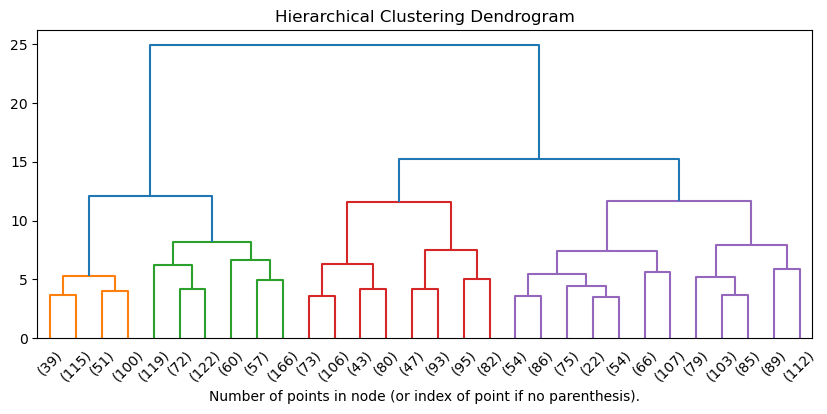

In [74]:
plt.figure(figsize=(10,4))
plt.title("Hierarchical Clustering Dendrogram")
res = dendrogram(links,truncate_mode="lastp",color_threshold=12)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

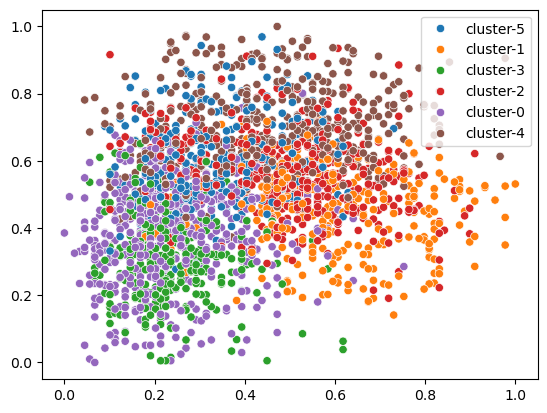

In [75]:
labels = ward.labels_
sns.scatterplot(x=train_data[:, 0], y=train_data[:, 1], hue=["cluster-{}".format(x) for x in labels])
plt.show()

In [76]:
print('average linkage')
average_linkage = AgglomerativeClustering(n_clusters=6, linkage='average', metric='manhattan',
                                              connectivity=connectivity)
average_linkage.fit(train_data)

hist, bins = np.histogram(average_linkage.labels_, 
                          bins=range(0, len(set(average_linkage.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, average_linkage.labels_))

average linkage
labels {0: 2442, 1: 3, 2: 2, 3: 3, 4: 1, 5: 1}
silhouette 0.07269714950379759


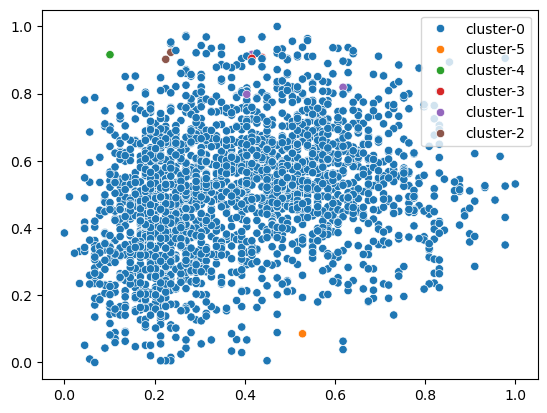

In [77]:
labels = average_linkage.labels_
sns.scatterplot(x=train_data[:, 0], y=train_data[:, 1], hue=["cluster-{}".format(x) for x in labels])
plt.show()

In [78]:
print('complete linkage')
complete_linkage = AgglomerativeClustering(n_clusters=5, linkage='complete', metric='l1',
                                              connectivity=connectivity)
complete_linkage.fit(train_data)
hist, bins = np.histogram(complete_linkage.labels_, 
                          bins=range(0, len(set(complete_linkage.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(train_data, complete_linkage.labels_))

complete linkage
labels {0: 107, 1: 342, 2: 3, 3: 799, 4: 1201}
silhouette -0.015627965700414605


In [79]:
ward.labels_

array([5, 5, 1, ..., 1, 0, 0], dtype=int64)

#scelgo quello con silhouette piu alta

In [80]:
df['hier_labels'] = ward.labels_

In [81]:
df

,vocal_channel,emotion,emotional_intensity,repetition,sex,channels,frame_width,length_ms,frame_count,intensity,...,calm,disgust,fearful,happy,neutral,sad,surprised,kmeans_label,dbscan_labels,hier_labels
0,0,fearful,0,2,1,1,2,3737,179379.0,-36.793432,...,0,0,1,0,0,0,0,4,0,5
1,0,angry,0,1,1,1,2,3904,187387.0,-37.443235,...,0,0,0,0,0,0,0,4,0,5
2,0,happy,1,2,1,1,2,4671,224224.0,-32.290737,...,0,0,0,1,0,0,0,3,0,1
3,0,surprised,0,1,1,1,2,3637,174575.0,-49.019839,...,0,0,0,0,0,0,1,2,0,3
4,1,happy,1,2,1,1,2,4404,211411.0,-31.214503,...,0,0,0,1,0,0,0,4,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,0,calm,1,1,0,1,2,4605,221021.0,-42.136827,...,1,0,0,0,0,0,0,2,0,0
2448,0,calm,0,1,0,1,2,4171,200200.0,-43.342901,...,1,0,0,0,0,0,0,1,0,0
2449,1,sad,1,2,0,1,2,5239,251451.0,-37.919308,...,0,0,0,0,0,1,0,5,0,1
2450,0,surprised,0,1,0,1,2,3737,179379.0,-45.751265,...,0,0,0,0,0,0,1,1,0,0


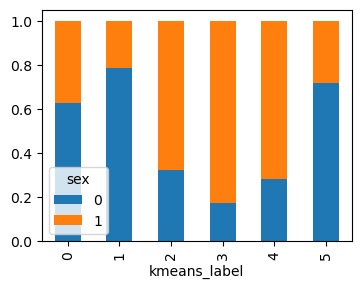

In [82]:
ct = pd.crosstab(df['kmeans_label'], df['sex'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.show()

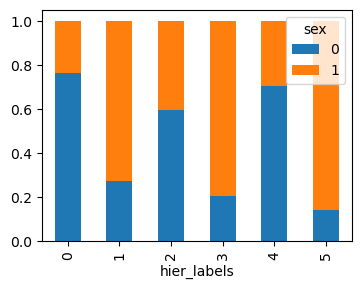

In [83]:
ct = pd.crosstab(df['hier_labels'], df['sex'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.show()

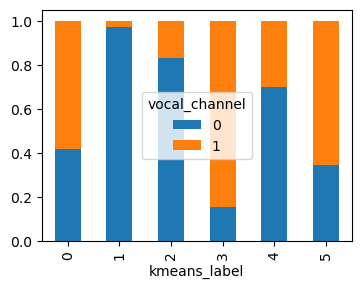

In [84]:
ct = pd.crosstab(df['kmeans_label'], df['vocal_channel'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.show()

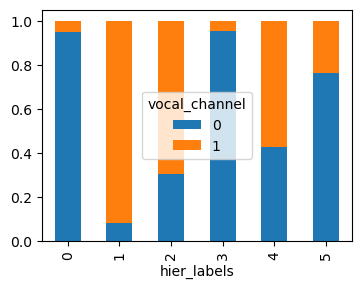

In [85]:
ct = pd.crosstab(df['hier_labels'], df['vocal_channel'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.show()

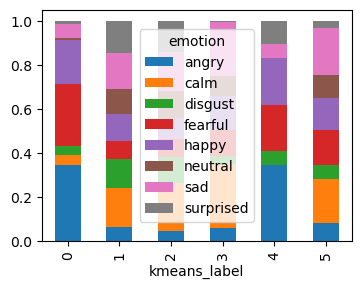

In [86]:
ct = pd.crosstab(df['kmeans_label'], df['emotion'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.show()

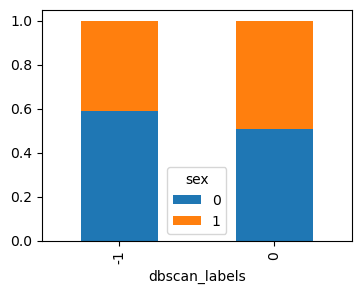

In [87]:
ct = pd.crosstab(df['dbscan_labels'], df['sex'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.show()

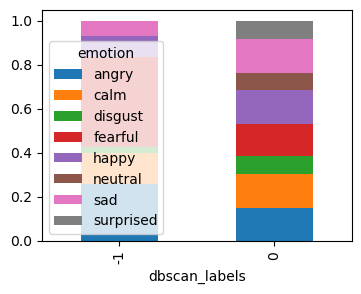

In [88]:
ct = pd.crosstab(df['dbscan_labels'], df['emotion'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))

plt.show()

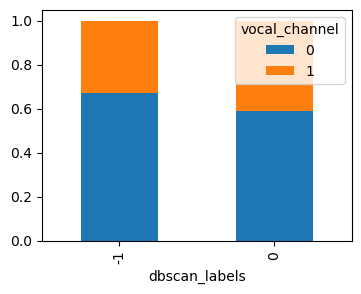

In [89]:
ct = pd.crosstab(df['dbscan_labels'], df['vocal_channel'])
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.show()

<Figure size 1500x600 with 0 Axes>

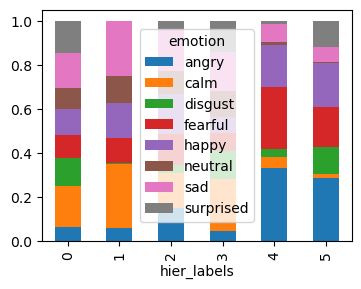

In [90]:
ct = pd.crosstab(df['hier_labels'], df['emotion'])
plt.figure(figsize=(15,6))
ct.div(ct.sum(axis=1), axis=0).plot(kind='bar', stacked=True, figsize=(4,3))
plt.show()

# Conclusione:
With any type of cluster i can identify very fast if it is Man or Female, or either if it has been Sing or Speech

## Invece le emotions non possono essere visualizati una a una per cluster

In [91]:
from scipy.spatial.distance import cdist

def sse_score(X, labels, return_centers=False):
    cluster_centers = list()
    tot_distance = 0.0
    for l in np.unique(labels):
        if l == -1:
            continue
        cluster = X[labels == l]
        center = cluster.mean(axis=0)
        dist = cdist(cluster, center.reshape(1,-1))
        tot_distance += dist.sum()
        cluster_centers.append(center)
    cluster_centers = np.array(cluster_centers)
    if return_centers:
        return tot_distance, cluster_centers

    return tot_distance

def bss_score(X, cluster_centers):
    data_center = X.mean(axis=0)
    dist = cdist(cluster_centers, data_center.reshape(1,-1))
    return dist.sum()

In [92]:
for alg in ['kmeans_label', 'dbscan_labels', 'hier_labels']:
    labels = df[alg]
    sse, cluster_centers = sse_score(train_data, labels, return_centers=True)
    bss = bss_score(train_data, cluster_centers)
    print('%s \t SSE %.2f  BSS %.2f' % (alg[:6], sse, bss))

kmeans 	 SSE 1482.98  BSS 3.18
dbscan 	 SSE 1877.85  BSS 0.02
hier_l 	 SSE 1538.54  BSS 3.01


Questo analisis non serve a nulla perche abbiamo diversi quantita di cluster in ogni metodo